In [ ]:
### 0. Ścieżki do plików CSV

"""
Ustawia wspólny katalog na wszystkie pliki CSV z tego notatnika.

OUTPUT_CSV_DIR – katalog na wyniki pośrednie (kandydaci na dc:subject itd.).
"""

import os

OUTPUT_CSV_DIR = "outputs/csv"
os.makedirs(OUTPUT_CSV_DIR, exist_ok=True)

### 1. Importy i konfiguracja klienta Google Vision (OCR)

In [1]:
### 1. Importy i konfiguracja klienta Google Vision (OCR)

from pathlib import Path
from datetime import datetime, timezone
import os
import time
import io
import json

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from google.cloud import vision
from google.oauth2 import service_account
from google.auth.exceptions import DefaultCredentialsError

"""
Inicjalizuje klienta Google Vision do OCR.

Założenia:
- pracujemy lokalnie na Macu,
- klucz usługi jest w pliku:
  /Users/olga/MetaLogic/secrets/vision-key.json
"""

CREDENTIALS_PATH = "/Users/olga/MetaLogic/secrets/vision-key.json"

try:
    creds = service_account.Credentials.from_service_account_file(CREDENTIALS_PATH)
    vision_client = vision.ImageAnnotatorClient(credentials=creds)
    print("Vision OK – użyto klucza:", CREDENTIALS_PATH)
except (FileNotFoundError, DefaultCredentialsError) as e:
    vision_client = None
    print("BŁĄD: nie udało się zainicjalizować Google Vision.")
    print("Szczegóły:", e)

Vision OK – użyto klucza: /Users/olga/MetaLogic/secrets/vision-key.json


### 2. Ścieżki wejścia/wyjścia (spójne z innymi notebookami)

In [ ]:
### 2. Ścieżki wejścia/wyjścia (spójne z innymi notebookami)

from pathlib import Path

PROJECT_ROOT = Path(".").resolve()

# katalog wejściowy z obrazami do OCR
IMAGE_ROOT = PROJECT_ROOT / "inputs"

# katalog wyjściowy na artefakty OCR (np. wizualizacje)
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "ocr"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# wspólny katalog na wszystkie CSV z modułów
OUTPUT_CSV_DIR = PROJECT_ROOT / "outputs" / "csv"
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)

# CSV z podsumowaniem OCR (pełny tekst)
CSV_PATH = OUTPUT_CSV_DIR / "ocr_results.csv"

# katalog / plik logów
RUNLOG_PATH = PROJECT_ROOT / "logs" / "runlog.jsonl"
RUNLOG_PATH.parent.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("IMAGE_ROOT:", IMAGE_ROOT, "| istnieje:", IMAGE_ROOT.exists())
print("Wyniki OCR →", CSV_PATH)

PROJECT_ROOT: /Users/olga/MetaLogic
IMAGE_ROOT: /Users/olga/MetaLogic/inputs | istnieje: True
Wyniki OCR → /Users/olga/MetaLogic/outputs/ocr/ocr_results.csv


### 3. Funkcje OCR (Google Vision – pełny obraz)

In [3]:
### 3. Funkcje OCR (Google Vision – pełny obraz)

import io
from PIL import Image
from google.cloud import vision


def ocr_image(image_path: Path, lang=("pl", "en")):
    """
    Wykonuje OCR całego obrazu (bez kafelków).

    Zwraca:
        lines      – lista odczytanych linii tekstu
        n_lines    – liczba linii
        total_chars – łączna liczba znaków
    """
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        content = buf.getvalue()

    image = vision.Image(content=content)

    response = vision_client.text_detection(
        image=image,
        image_context=vision.ImageContext(language_hints=list(lang))
    )

    if response.error.message:
        print("Błąd Vision API:", response.error.message)
        return [], 0, 0

    annotations = response.text_annotations
    if not annotations:
        return [], 0, 0

    full_text = annotations[0].description
    lines = [ln.strip() for ln in full_text.split("\n") if ln.strip()]

    total_chars = sum(len(ln) for ln in lines)
    return lines, len(lines), total_chars

### 4. Batch OCR dla wszystkich obrazów w katalogu

In [13]:
### 4. Przygotowanie listy obrazów do OCR

from typing import List

# obsługiwane rozszerzenia plików graficznych
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}


def list_images(image_root: Path) -> List[Path]:
    """
    Zwraca listę ścieżek do obrazów w IMAGE_ROOT
    o rozszerzeniach z IMAGE_EXTENSIONS.
    """
    return sorted(
        p for p in image_root.glob("*")
        if p.suffix.lower() in IMAGE_EXTENSIONS and p.is_file()
    )


if vision_client is None:
    print("Brak klienta Google Vision – pomijam OCR.")
    image_paths = []
else:
    image_paths = list_images(IMAGE_ROOT)
    print(f"Liczba obrazów do OCR: {len(image_paths)}")

Liczba obrazów do OCR: 50


### 5. OCR wszystkich obrazów i zapis pełnego tekstu do CSV

In [ ]:
### 5. OCR wszystkich obrazów i zapis pełnego tekstu do CSV

import pandas as pd
from IPython.display import display

if vision_client is None:
    print("Brak klienta Google Vision – nie wykonuję OCR.")
    df_ocr = pd.DataFrame()
elif not image_paths:
    print("Brak obrazów w IMAGE_ROOT – nic do OCR.")
    df_ocr = pd.DataFrame()
else:
    records = []

    for i, img_path in enumerate(image_paths, start=1):
        print(f"[{i}/{len(image_paths)}] {img_path.name}")

        # używamy funkcji ocr_image z komórki 3
        lines, n_lines, total_chars = ocr_image(img_path)

        # pełny tekst rekonstruowany z linii (dla CSV)
        full_text = "\n".join(lines) if lines else ""

        records.append(
            {
                "file_path": str(img_path.relative_to(PROJECT_ROOT)),
                "n_lines": n_lines,
                "total_chars": total_chars,
                "full_text": full_text,
                "has_text": bool(n_lines > 0),
            }
        )

    df_ocr = pd.DataFrame(records)
    df_ocr.to_csv(CSV_PATH, index=False)
    print("Zapisano CSV:", CSV_PATH)
    display(df_ocr.head())

[1/50] 0004.jpg
[2/50] 0006.jpg
[3/50] 0009.jpg
[4/50] 0022.jpg
[5/50] 0034.jpg
[6/50] 0043.jpg
[7/50] 0044.jpg
[8/50] 0074.jpg
[9/50] 0075.jpg
[10/50] 0077.jpg
[11/50] 0106.jpg
[12/50] 0109.jpg
[13/50] 0115.jpg
[14/50] 0116.jpg
[15/50] 0124.jpg
[16/50] 0125.jpg
[17/50] 0126.jpg
[18/50] 0127.jpg
[19/50] 0128.jpg
[20/50] 0135.jpg
[21/50] 0136.jpg
[22/50] 0138.jpg
[23/50] 0143.jpg
[24/50] 0145.jpg
[25/50] 0161.jpg
[26/50] 0165.jpg
[27/50] 0171.jpg
[28/50] 0174.jpg
[29/50] 0175.jpg
[30/50] 0187 2.jpg
[31/50] 0187.jpg
[32/50] 0188.jpg
[33/50] 0189.jpg
[34/50] 0196.jpg
[35/50] 0203.jpg
[36/50] 0204.jpg
[37/50] 0205.jpg
[38/50] 0211.jpg
[39/50] 0223.jpg
[40/50] 0226.jpg
[41/50] 0229.jpg
[42/50] 0233.jpg
[43/50] 0241.jpg
[44/50] 0242.jpg
[45/50] 0253.jpg
[46/50] 0256.jpg
[47/50] 0275.jpg
[48/50] 0282.jpg
[49/50] 0286.jpg
[50/50] 0295.jpg
Zapisano CSV: /Users/olga/MetaLogic/outputs/ocr/ocr_results.csv


,file_path,n_lines,total_chars,full_text,has_text
0,inputs/0004.jpg,18,166,"ARCEY\n188\nCWIKŁAWIKŁA\nPARD\n12""\nCWIKŁ\nCWI...",True
1,inputs/0006.jpg,3,13,35 lat\nZTL\nUMCS,True
2,inputs/0009.jpg,2,39,REF\nA TO SZANS LA POLSKI I KAŻDEGO Z NAS,True
3,inputs/0022.jpg,2,43,JAWNOŚĆ I PRAWORS\nFILARK KULTURY POLITICINES,True
4,inputs/0034.jpg,0,0,,False


### 6. Podgląd miniatur z zaznaczonym tekstem OCR

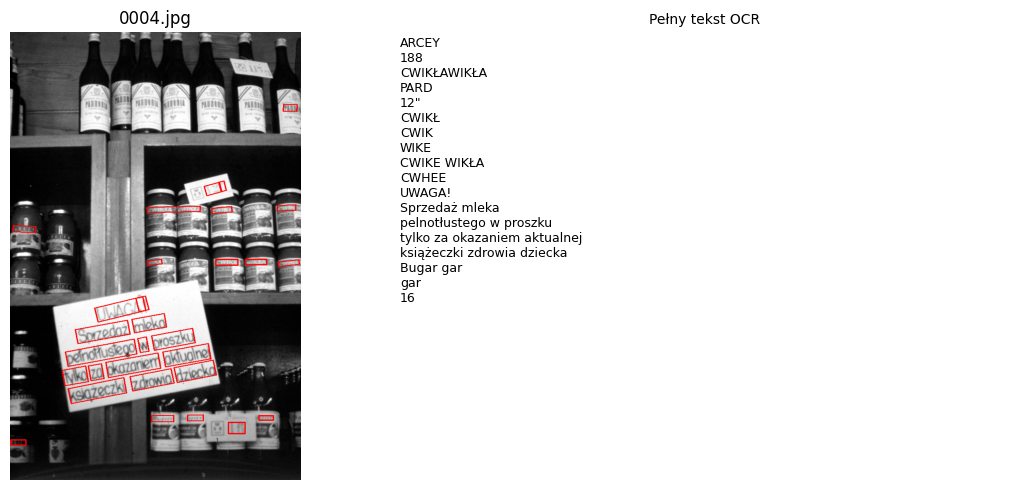

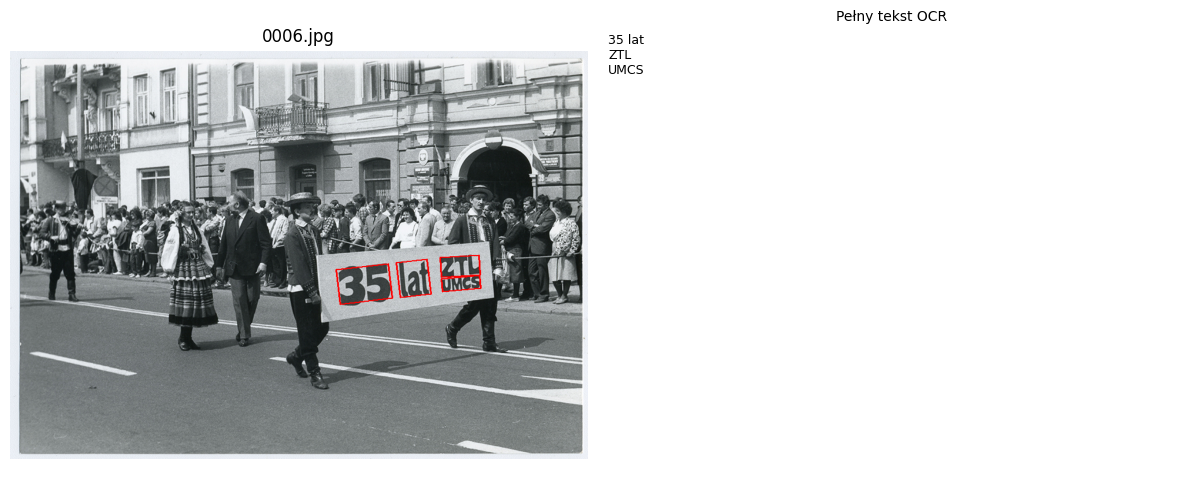

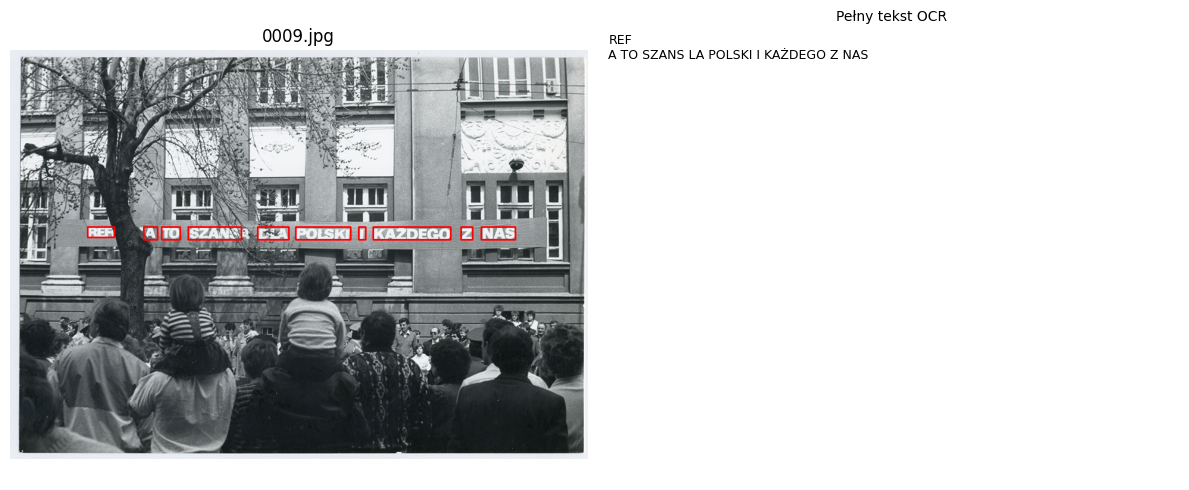

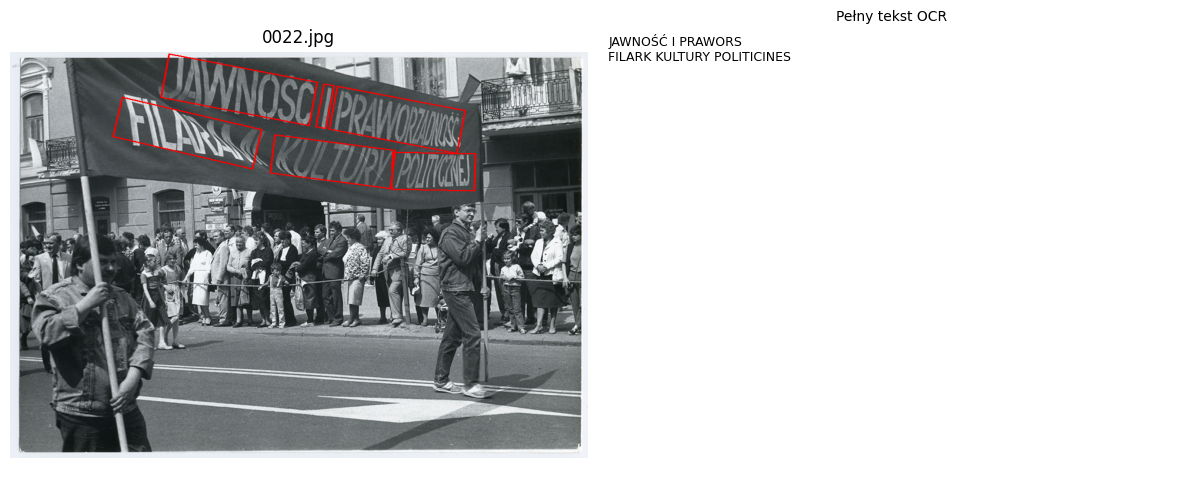

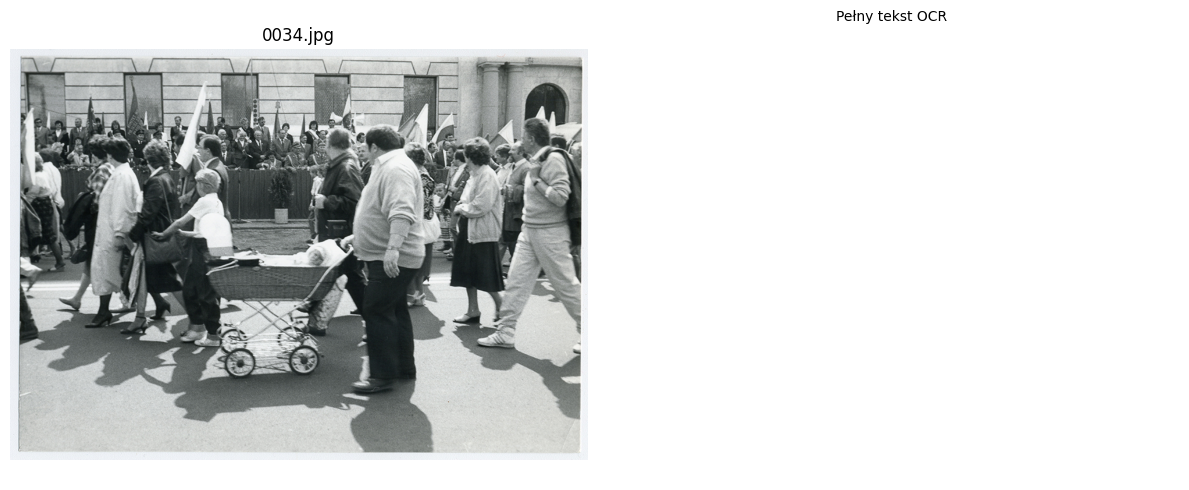

In [15]:
### 6. Miniatury z boxami OCR i pełnym tekstem obok

from PIL import ImageDraw
import matplotlib.pyplot as plt
import io


def draw_ocr_boxes(image_path: Path):
    """
    Zwraca obraz z narysowanymi boxami OCR (wywołuje Vision dla pojedynczego pliku).
    """
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        content = buf.getvalue()

    image = vision.Image(content=content)
    response = vision_client.text_detection(image=image)

    annotations = response.text_annotations
    if not annotations:
        return img

    draw = ImageDraw.Draw(img)

    # rysujemy boxy dla poszczególnych fragmentów tekstu
    for ann in annotations[1:]:
        vertices = ann.bounding_poly.vertices
        box = [(v.x, v.y) for v in vertices]
        draw.line(box + [box[0]], width=3, fill="red")

    return img


def show_ocr_thumbnails_with_text(image_paths, df_ocr, n: int = 5):
    """
    Pokazuje n miniatur z boxami OCR oraz pełny tekst z df_ocr po prawej.
    """
    if vision_client is None:
        print("Brak klienta Google Vision – nie można narysować boxów.")
        return

    if df_ocr.empty:
        print("df_ocr jest pusty – najpierw uruchom komórkę 5 (OCR + CSV).")
        return

    sample_paths = image_paths[:n]

    for p in sample_paths:
        vis = draw_ocr_boxes(p)
        rel_path = str(p.relative_to(PROJECT_ROOT))

        row = df_ocr[df_ocr["file_path"] == rel_path]
        if not row.empty:
            text = row.iloc[0]["full_text"]
        else:
            text = "(brak wpisu w df_ocr)"

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].imshow(vis)
        axes[0].set_title(p.name)
        axes[0].axis("off")

        axes[1].axis("off")
        axes[1].set_title("Pełny tekst OCR", fontsize=10)
        axes[1].text(
            0.01,
            0.99,
            text,
            va="top",
            ha="left",
            wrap=True,
            fontsize=9,
        )

        plt.tight_layout()
        plt.show()


# przykładowe wywołanie podglądu:
show_ocr_thumbnails_with_text(image_paths, df_ocr, n=5)